## Import des packages

In [1]:
from scipy.stats import binom
from scipy import signal
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd
import math
from sklearn import linear_model
from sklearn.metrics import mean_squared_error
from datetime import datetime
from statsmodels.tsa.arima_model import ARIMA
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import TimeSeriesSplit
import seaborn as sns 
from scipy import stats
import statsmodels.graphics.tsaplots as tsa

### Question 1

In [288]:
data_open = pd.read_csv('OpenhealthS-Grippal.csv', delimiter=';')

In [289]:
data_open.head()

,PERIODE,IAS_brut,IAS_lisse,Incidence_Sentinelles
0,2009-07-01,"1,7","2,2","2,3"
1,2009-07-02,"3,4","2,1","2,3"
2,2009-07-03,"2,1","2,1","2,3"
3,2009-07-04,"1,3",2,"2,3"
4,2009-07-05,"14,2",2,"2,3"


In [290]:
data_open.dtypes

PERIODE                  object
IAS_brut                 object
IAS_lisse                object
Incidence_Sentinelles    object
dtype: object

In [291]:
data_open.shape

(1752, 4)

In [292]:
data_open['IAS_brut'] = data_open['IAS_brut'].str.replace(',', '.')

In [293]:
data_open['IAS_brut'] = pd.to_numeric(data_open['IAS_brut'])
data_open['PERIODE'] = pd.to_datetime(data_open['PERIODE'])

In [294]:
data_open.head()

,PERIODE,IAS_brut,IAS_lisse,Incidence_Sentinelles
0,2009-07-01,1.7,"2,2","2,3"
1,2009-07-02,3.4,"2,1","2,3"
2,2009-07-03,2.1,"2,1","2,3"
3,2009-07-04,1.3,2,"2,3"
4,2009-07-05,14.2,2,"2,3"


In [295]:
date_max = data_open['PERIODE'].max()
date_min = data_open['PERIODE'].min()

#### Valeurs nulles

In [296]:
valeurs_null = data_open.loc[data_open['IAS_brut'] == 0].index

In [297]:
valeurs_null

Int64Index([340, 378, 627, 732, 858, 1062, 1075, 1502], dtype='int64')

In [298]:
data_open.loc[341]

PERIODE                  2010-06-07 00:00:00
IAS_brut                                   1
IAS_lisse                                0,9
Incidence_Sentinelles                    0,9
Name: 341, dtype: object

In [299]:
for i in valeurs_null:
    data_open.loc[i,'IAS_brut' ] = (data_open.loc[i+1,'IAS_brut'] + data_open.loc[i-1,'IAS_brut']) / 2

### Question 2

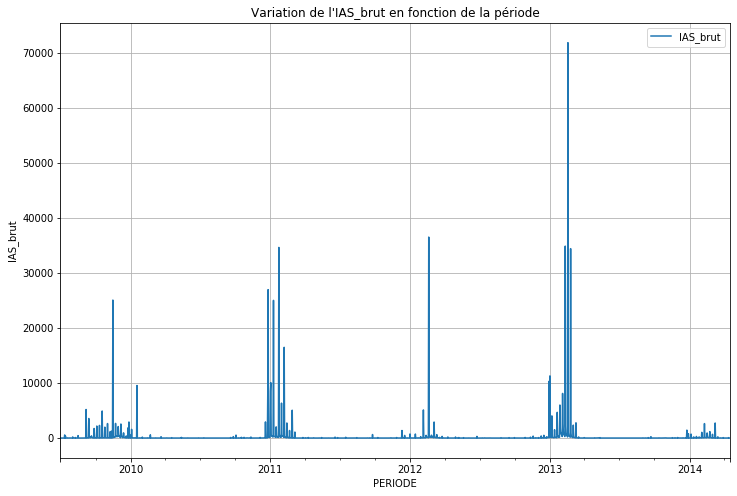

In [301]:
data_open.plot(x='PERIODE', y='IAS_brut', figsize=(12,8))
plt.ylabel('IAS_brut')
plt.title("Variation de l'IAS_brut en fonction de la période")
plt.grid()

On observe en général les pics d'IAS_brut en hiver entre Janvier et avril avec le pic le plus important survenu en Février 2013.

### Question 3

Text(0.5, 1.0, 'Histogramme de la loi marginale')

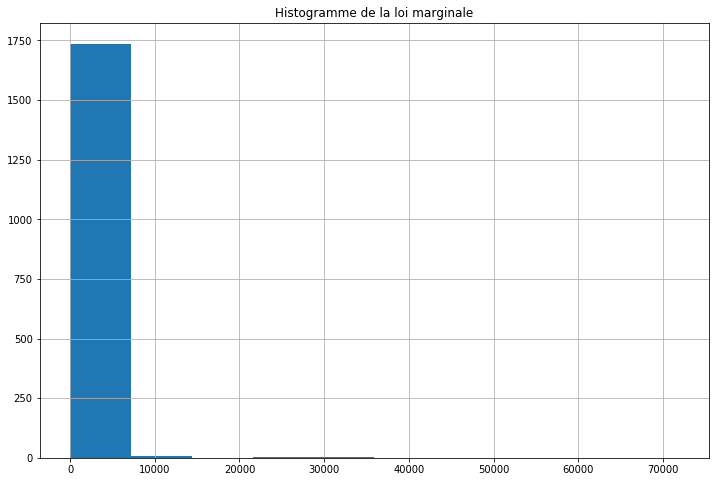

In [303]:
data_open['IAS_brut'].hist(figsize=(12,8))
plt.title('Histogramme de la loi marginale')

### Question 4

A partir de cette question, travailler uniquement avec les données logarithmiques

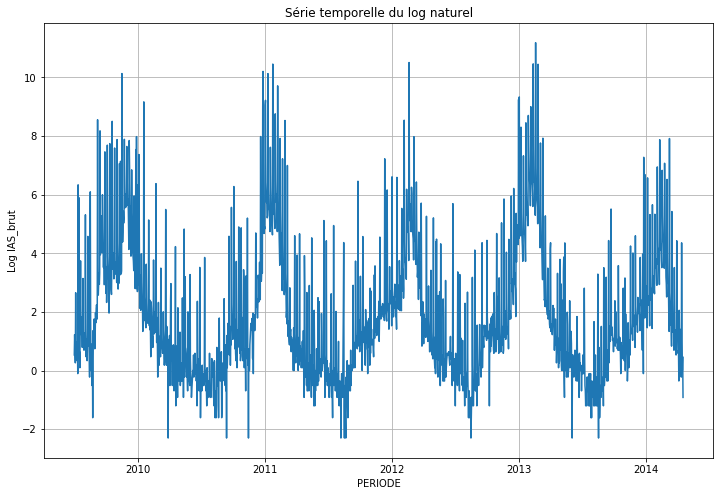

In [305]:
plt.figure(figsize = (12,8))
x = data_open['PERIODE']
y = np.log(data_open['IAS_brut'])
plt.plot(x, y)
plt.grid()
plt.title('Série temporelle du log naturel')
plt.xlabel('PERIODE')
plt.ylabel('Log IAS_brut')
plt.show()

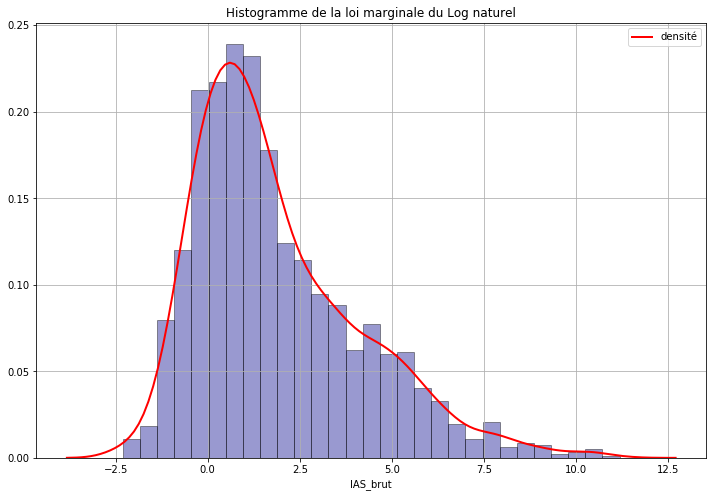

In [309]:
plt.figure(figsize = (12,8))
sns.distplot(y, color = 'darkblue', hist = True, hist_kws={'edgecolor':'black'},
                 kde=True, kde_kws = {'color': 'red', 'lw': 2, 'label':'densité'})
plt.title('Histogramme de la loi marginale du Log naturel')
plt.grid()

Le log naturel permet de mieux visualiser la variation de l'IAS_brut entre, les mois d'une même année et d'une année à l'autre

### Question 5

In [312]:
IAS = data_open.set_index('PERIODE')['IAS_brut']

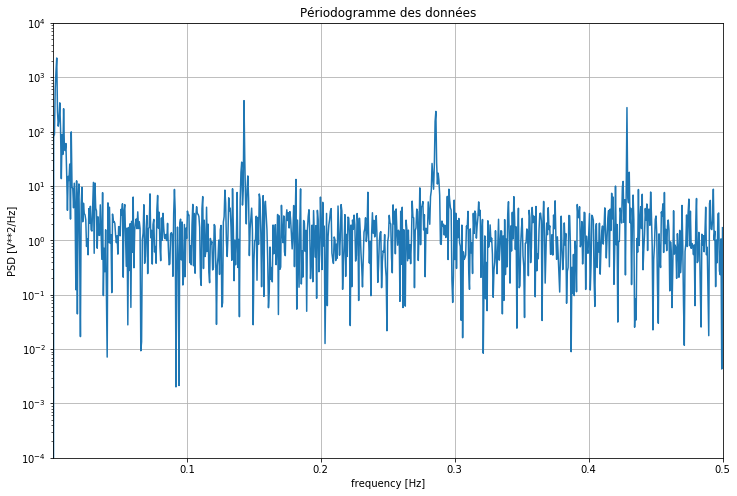

In [317]:
f, Pxx_den = signal.periodogram(np.log(data_open['IAS_brut']))
plt.figure(figsize = (12,8))
plt.semilogy(f, Pxx_den)
plt.xlim([1e-10, 0.5])
plt.ylim([1e-4, 1e+4])
#plt.plot(f, Pxx_den)
plt.xlabel('frequency [Hz]')
plt.ylabel('PSD [V**2/Hz]')
plt.title('Périodogramme des données')
plt.grid()
plt.show()

Les pics les plus significatifs correspondent aux valeurs ne pouvant être expliquées par le bruit de fond

### Question 6

In [319]:
data_open_log = pd.DataFrame(data_open, columns=['PERIODE', 'IAS_brut'])

In [320]:
data_open_log.head()

,PERIODE,IAS_brut
0,2009-07-01,1.7
1,2009-07-02,3.4
2,2009-07-03,2.1
3,2009-07-04,1.3
4,2009-07-05,14.2


In [321]:
data_open_log['IAS_brut'] = np.log(data_open_log['IAS_brut'])

In [322]:
data_open_log = data_open_log.set_index('PERIODE')

In [323]:
data_open_log.head()

,IAS_brut
PERIODE,
2009-07-01,0.530628
2009-07-02,1.223775
2009-07-03,0.741937
2009-07-04,0.262364
2009-07-05,2.653242


In [324]:
shift = data_open_log.shift(365)

In [325]:
data_open_shift = data_open_log - shift

In [326]:
data_open_shift.head()

,IAS_brut
PERIODE,
2009-07-01,NaN
2009-07-02,NaN
2009-07-03,NaN
2009-07-04,NaN
2009-07-05,NaN


In [327]:
data_open_shift = data_open_shift[data_open_shift['IAS_brut'].isna() == False]

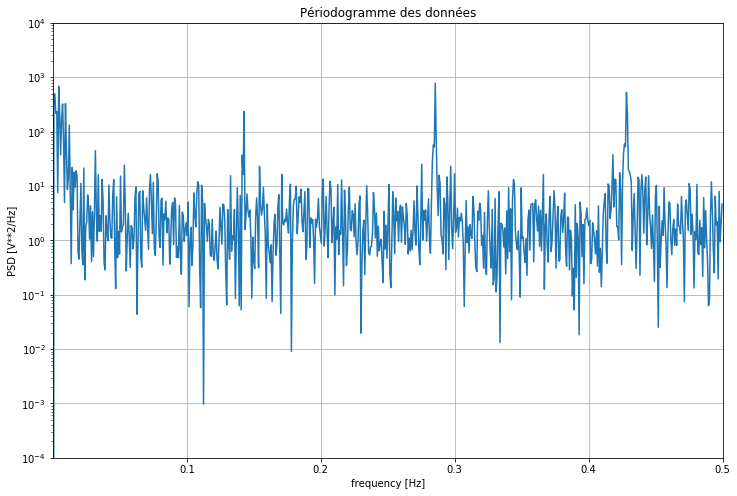

In [328]:
f, Pxx_den = signal.periodogram(data_open_shift['IAS_brut'])
plt.figure(figsize = (12,8))
plt.semilogy(f, Pxx_den)
#plt.plot(f, Pxx_den)
plt.xlim([1e-10, 0.5])
plt.ylim([1e-4, 1e+4])
plt.xlabel('frequency [Hz]')
plt.ylabel('PSD [V**2/Hz]')
plt.title('Périodogramme des données')
plt.grid()
plt.show()

Cette fonction a fait disparaître quelques pics entre 0 et 0.1 qui représentaient le bruit dans nos données

### Question 7

In [340]:
data_tot = data_open_log.reset_index()

In [341]:
data_tot.head()

,PERIODE,IAS_brut
0,2009-07-01,0.530628
1,2009-07-02,1.223775
2,2009-07-03,0.741937
3,2009-07-04,0.262364
4,2009-07-05,2.653242


In [346]:
for i in range(len(data_tot)):
    data_tot.loc[i, 't'] = i

In [348]:
data_tot = data_tot.set_index('PERIODE')

In [349]:
n_harmo = 6
T = 365
for k in range(1, n_harmo):
        data_tot['cos'+str(k)] = np.cos(data_tot['t']*k*2*math.pi/T)
        data_tot['sin'+str(k)] = np.sin(data_tot['t']*k*2*math.pi/T)

In [350]:
data_tot = data_tot.drop(columns=['t'])
data_tot.head()

,IAS_brut,cos1,sin1,cos2,sin2,cos3,sin3,cos4,sin4,cos5,sin5
PERIODE,,,,,,,,,,,
2009-07-01,0.530628,1.000000,0.000000,1.000000,0.000000,1.000000,0.000000,1.000000,0.000000,1.000000,0.000000
2009-07-02,1.223775,0.999852,0.017213,0.999407,0.034422,0.998667,0.051620,0.997630,0.068802,0.996298,0.085965
2009-07-03,0.741937,0.999407,0.034422,0.997630,0.068802,0.994671,0.103102,0.990532,0.137279,0.985220,0.171293
2009-07-04,0.262364,0.998667,0.051620,0.994671,0.103102,0.988023,0.154309,0.978740,0.205104,0.966848,0.255353
2009-07-05,2.653242,0.997630,0.068802,0.990532,0.137279,0.978740,0.205104,0.962309,0.271958,0.941317,0.337523


In [351]:
data_test = data_tot.loc['2013-04-01':'2014-04-17']
data_train = data_tot.loc['2009-07-01':'2013-03-31']

In [352]:
train_cols =['cos1','sin1','cos2','sin2','cos3','sin3','cos4','sin4','cos5','sin5']
data_train_x = data_train[train_cols]
data_train_y = data_train['IAS_brut']

data_test_x = data_test[train_cols]
data_test_y = data_test['IAS_brut']

In [353]:
model_linear = linear_model.LinearRegression(fit_intercept=True)
model_linear.fit(data_train_x, data_train_y)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

In [354]:
data_test_y_predict = model_linear.predict(data_test_x)
risque_quad = mean_squared_error(data_test_y, data_test_y_predict)
print('La valeur du risque quadratique est : '+str(round(risque_quad,3)))

La valeur du risque quadratique est : 1.88


In [355]:
data_tot['IAS_brut_pred'] = model_linear.predict(data_tot[train_cols])

In [356]:
data_tot.head()

,IAS_brut,cos1,sin1,cos2,sin2,cos3,sin3,cos4,sin4,cos5,sin5,IAS_brut_pred
PERIODE,,,,,,,,,,,,
2009-07-01,0.530628,1.000000,0.000000,1.000000,0.000000,1.000000,0.000000,1.000000,0.000000,1.000000,0.000000,0.488336
2009-07-02,1.223775,0.999852,0.017213,0.999407,0.034422,0.998667,0.051620,0.997630,0.068802,0.996298,0.085965,0.498346
2009-07-03,0.741937,0.999407,0.034422,0.997630,0.068802,0.994671,0.103102,0.990532,0.137279,0.985220,0.171293,0.507135
2009-07-04,0.262364,0.998667,0.051620,0.994671,0.103102,0.988023,0.154309,0.978740,0.205104,0.966848,0.255353,0.514574
2009-07-05,2.653242,0.997630,0.068802,0.990532,0.137279,0.978740,0.205104,0.962309,0.271958,0.941317,0.337523,0.520541


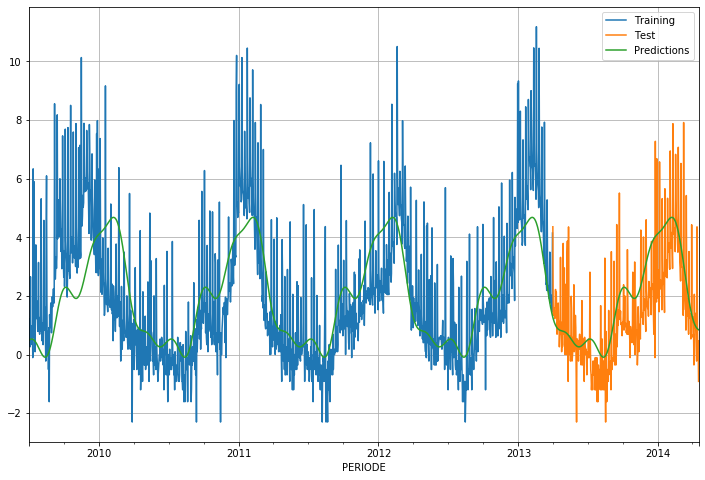

In [358]:
plt.figure(figsize = (12,8))
data_tot['IAS_brut']['2009-07-01':'2013-03-31'].plot(label="Training")
data_tot['IAS_brut']['2013-04-01':'2014-04-17'].plot(label="Test")
data_tot['IAS_brut_pred'].plot(label="Predictions")
plt.legend()
plt.grid()
plt.show()

### Courbe des résidus

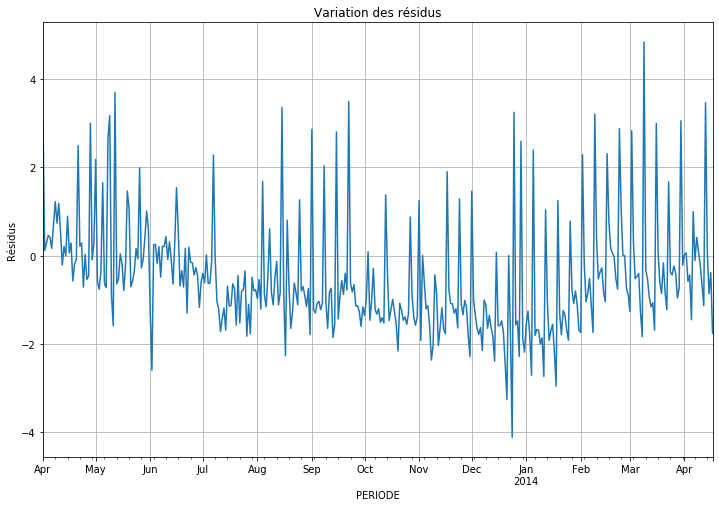

In [359]:
plt.figure(figsize = (12,8))
(data_test_y - data_test_y_predict).plot()
plt.ylabel("Résidus")
plt.title("Variation des résidus")
plt.grid()
plt.show()

In [360]:
n_harmo = 6
cols = data_tot.columns[1:]
cols_cos = []
cols_sin = []
mean_square_arr = []
for k in range(1, n_harmo):
    cols_cos.append('cos'+str(k))
    cols_sin.append('sin'+str(k))
    
    cols_reg = cols_cos + cols_sin
    data_train_x_h = data_train[cols_reg]
    data_train_y_h = data_train['IAS_brut']

    data_test_x_h = data_test[cols_reg]
    data_test_y_h = data_test['IAS_brut']
    
    model_linear_h = linear_model.LinearRegression(fit_intercept=True)
    model_linear_h.fit(data_train_x_h, data_train_y_h)
    
    data_test_y_predict_h = model_linear_h.predict(data_test_x_h)
    risque_quad_h = mean_squared_error(data_test_y_h, data_test_y_predict_h)
    mean_square_arr.append(risque_quad_h)

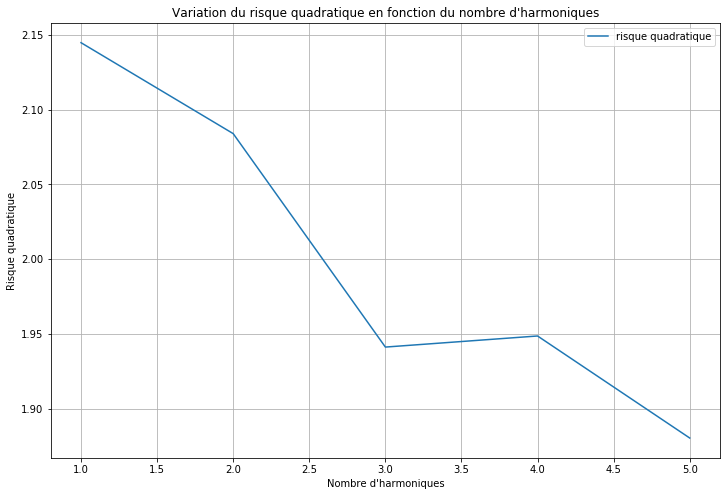

In [363]:
plt.figure(figsize = (12,8))
plt.plot(np.arange(1,6), mean_square_arr, label='risque quadratique')
plt.xlabel("Nombre d'harmoniques")
plt.ylabel("Risque quadratique")
plt.title("Variation du risque quadratique en fonction du nombre d'harmoniques")
plt.grid()
plt.legend()
plt.show()

## Données “Trafic internet” 

### Question 8

In [22]:
col_int = ["time_stamp", "source_host", "destination_host", "source_port", "destination_port", "bytes"]

In [23]:
data_int = pd.read_csv("lbl-tcp-3.tcp", delimiter=" ", names = col_int, header=None)

In [24]:
data_int.head()

,time_stamp,source_host,destination_host,source_port,destination_port,bytes
0,7.591038e+08,1,2,23,2436,1
1,1.044500e-02,2,1,2436,23,2
2,2.377500e-02,1,2,23,2436,2
3,2.655800e-02,2,1,2436,23,1
4,2.900200e-02,3,4,3930,119,42


In [25]:
data_int['datetime'] = pd.to_datetime(data_int['time_stamp'], unit='s')

In [26]:
data_int['datetime'] = data_int['datetime'].astype('str')

In [27]:
data_int['datetime']= pd.to_datetime(data_int['datetime'].str.split('.').str[0])

In [28]:
data_int.head()

,time_stamp,source_host,destination_host,source_port,destination_port,bytes,datetime
0,7.591038e+08,1,2,23,2436,1,1994-01-20 22:10:00
1,1.044500e-02,2,1,2436,23,2,1970-01-01 00:00:00
2,2.377500e-02,1,2,23,2436,2,1970-01-01 00:00:00
3,2.655800e-02,2,1,2436,23,1,1970-01-01 00:00:00
4,2.900200e-02,3,4,3930,119,42,1970-01-01 00:00:00


In [32]:
data_int_group_ = data_int.loc[1:]

In [35]:
data_int_group_.dtypes

time_stamp                 float64
source_host                  int64
destination_host             int64
source_port                  int64
destination_port             int64
bytes                        int64
datetime            datetime64[ns]
dtype: object

In [36]:
data_int_group_ = data_int_group_.drop(columns=['time_stamp','source_host','destination_host','source_port','destination_port'])

In [40]:
data_int_group_ = data_int_group_.set_index('datetime')

In [46]:
data_int_group = data_int_group_.resample('10S', how={'bytes':'count'})

/home/parfait/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: FutureWarning: how in .resample() is deprecated
the new syntax is .resample(...)..apply(<func>)
  """Entry point for launching an IPython kernel.


In [47]:
data_int_group.head()

,bytes
datetime,
1970-01-01 00:00:00,1614
1970-01-01 00:00:10,1729
1970-01-01 00:00:20,3220
1970-01-01 00:00:30,1767
1970-01-01 00:00:40,1891


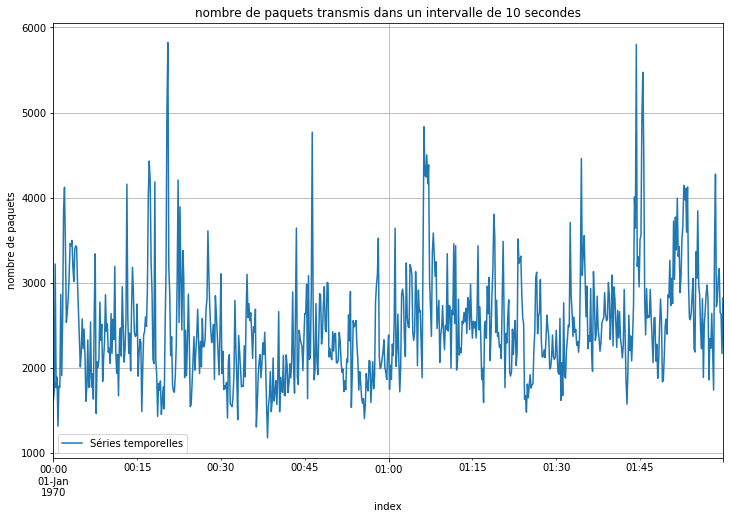

In [51]:
plt.figure(figsize = (12,8))
data_int_group['bytes'].plot(label="Séries temporelles")
plt.title('nombre de paquets transmis dans un intervalle de 10 secondes')
plt.xlabel('index')
plt.ylabel('nombre de paquets')
plt.grid()
plt.legend()
plt.show()

### Question 9

#### Méthode AIC et BIC

In [52]:
data_int_train = data_int_group['1970-01-01 00:00:00':'1970-01-01 01:15:00']['bytes']
data_int_test = data_int_group['1970-01-01 01:15:01':]['bytes']

In [53]:
aic_arr = []
bic_arr = []
for p in range(1,15):
    model_arima = ARIMA(data_int_train, order=(p,1,0))
    model_fit_arima = model_arima.fit(disp=0)
    aic_ = model_fit_arima.aic
    bic_ = model_fit_arima.bic
    aic_arr.append(aic_)
    bic_arr.append(bic_)

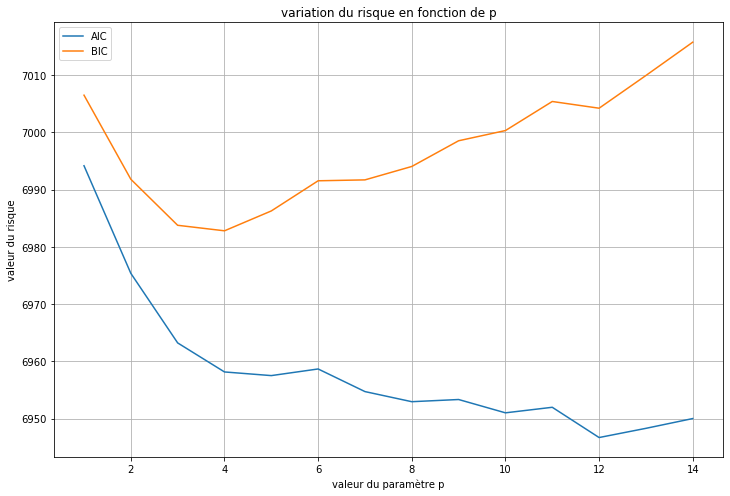

In [54]:
plt.figure(figsize = (12,8))
plt.plot(np.arange(1,15), aic_arr, label='AIC')
plt.plot(np.arange(1,15), bic_arr, label='BIC')
plt.xlabel('valeur du paramètre p')
plt.ylabel('valeur du risque')
plt.title('variation du risque en fonction de p')
plt.grid()
plt.legend()
plt.show()

#### Cross validation

In [55]:
tscv = TimeSeriesSplit(n_splits=4)
risque_mean = []
for p in range(1,12):
    risque_int = []
    for train_index, test_index in tscv.split(data_int_group):
        data_train = data_int_group[min(train_index):]['bytes']
        data_test = data_int_group[min(test_index):]['bytes']
        model_arima = ARIMA(data_train, order=(p,1,0))
        model_fit_arima = model_arima.fit(disp=0)
        prediction = model_fit_arima.predict(start=min(data_test.index), end=max(data_test.index))
        risque_quad_cv = mean_squared_error(data_test, prediction)
        risque_int.append(risque_quad_cv)
    risque_mean.append(np.mean(risque_int))

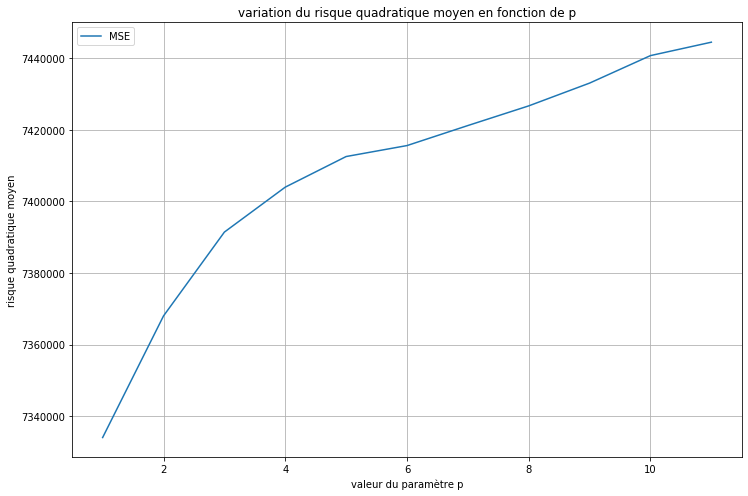

In [56]:
plt.figure(figsize = (12,8))
plt.plot(np.arange(1,12), risque_mean, label='MSE')
plt.xlabel('valeur du paramètre p')
plt.ylabel('risque quadratique moyen')
plt.title('variation du risque quadratique moyen en fonction de p')
plt.grid()
plt.legend()
plt.show()

### Question 10

In [57]:
# fit model
model_arima = ARIMA(data_int_train, order=(12,1,0))
model_fit_arima = model_arima.fit(disp=0)
model_fit_arima.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                             ARIMA Model Results                              
==============================================================================
Dep. Variable:                D.bytes   No. Observations:                  450
Model:                ARIMA(12, 1, 0)   Log Likelihood               -3459.351
Method:                       css-mle   S.D. of innovations            527.174
Date:                Sun, 26 Jan 2020   AIC                           6946.702
Time:                        02:49:36   BIC                           7004.231
Sample:                    01-01-1970   HQIC                          6969.376
                         - 01-01-1970                                         
==================================================================================
                     coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------
const              1.0647      6.605      0.161      0.872     -11.881      14.010
ar.L1.D.bytes     -0.4167      0.047     -8.909      0.000      -0.508      -0.325
ar.L2.D.bytes     -0.3854      0.051     -7.586      0.000      -0.485      -0.286
ar.L3.D.bytes     -0.3308      0.053     -6.205      0.000      -0.435      -0.226
ar.L4.D.bytes     -0.2672      0.055     -4.855      0.000      -0.375      -0.159
ar.L5.D.bytes     -0.2174      0.056     -3.906      0.000      -0.327      -0.108
ar.L6.D.bytes     -0.1875      0.056     -3.370      0.001      -0.297      -0.078
ar.L7.D.bytes     -0.2346      0.055     -4.227      0.000      -0.343      -0.126
ar.L8.D.bytes     -0.1996      0.056     -3.559      0.000      -0.310      -0.090
ar.L9.D.bytes     -0.1572      0.055     -2.847      0.005      -0.265      -0.049
ar.L10.D.bytes    -0.1673      0.054     -3.115      0.002      -0.273      -0.062
ar.L11.D.bytes    -0.1019      0.051     -1.980      0.048      -0.203      -0.001
ar.L12.D.bytes    -0.1296      0.048     -2.711      0.007      -0.223      -0.036
                                    Roots                                     
==============================================================================
                   Real          Imaginary           Modulus         Frequency
------------------------------------------------------------------------------
AR.1             1.0251           -0.4854j            1.1342           -0.0704
AR.2             1.0251           +0.4854j            1.1342            0.0704
AR.3             0.7105           -0.9651j            1.1985           -0.1490
AR.4             0.7105           +0.9651j            1.1985            0.1490
AR.5             0.2206           -1.1592j            1.1800           -0.2201
AR.6             0.2206           +1.1592j            1.1800            0.2201
AR.7            -1.1362           -0.2967j            1.1742           -0.4593
AR.8            -1.1362           +0.2967j            1.1742            0.4593
AR.9            -0.8309           -0.8551j            1.1923           -0.3727
AR.10           -0.8309           +0.8551j            1.1923            0.3727
AR.11           -0.3822           -1.1763j            1.2368           -0.3000
AR.12           -0.3822           +1.1763j            1.2368            0.3000
------------------------------------------------------------------------------
"""

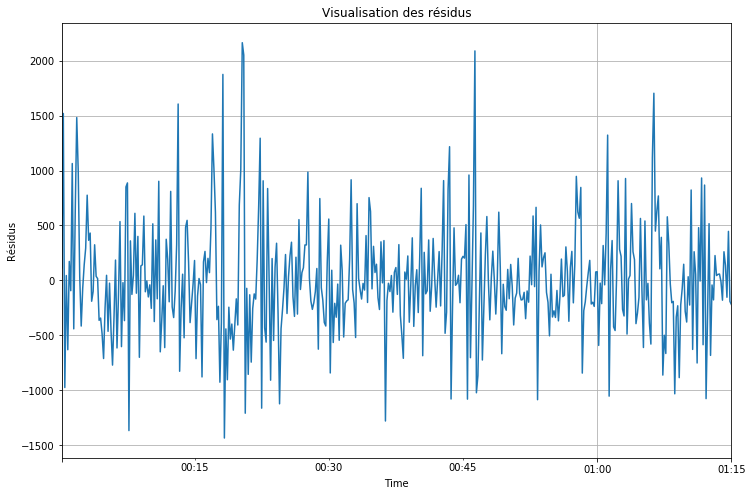

In [59]:
# plot residual errors
plt.figure(figsize = (12,8))
residuals = model_fit_arima.resid
residuals.plot()
plt.title('Visualisation des résidus')
plt.grid()
plt.xlabel('Time')
plt.ylabel('Résidus')
plt.show()

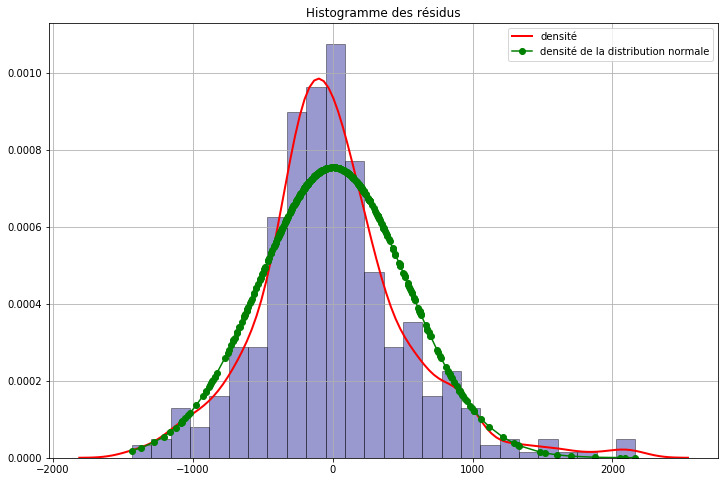

In [61]:
plt.figure(figsize = (12,8))
res = residuals.sort_values(0)
norm_ = stats.norm.pdf(res, np.mean(res), np.std(res))
sns.distplot(residuals, color = 'darkblue', hist = True, hist_kws={'edgecolor':'black'},
                 kde=True, kde_kws = {'color': 'red', 'lw': 2, 'label':'densité'})
plt.plot(res,norm_,'-o', color='green', label='densité de la distribution normale')
plt.title('Histogramme des résidus')
plt.legend()
plt.grid()

On Constate que les résidus ne sont pas distribués suivant une loi normale centrée.

## Données “Southern oscillation index” 

### Question 11

In [62]:
data_soi = pd.read_csv("soi.tsv", delimiter="\t", header=None).T
data_soi.head()

,0
0,1.537160
1,0.922168
2,-0.104204
3,-0.291903
4,-0.658745


In [63]:
data_soi = data_soi.dropna()

### Question 12

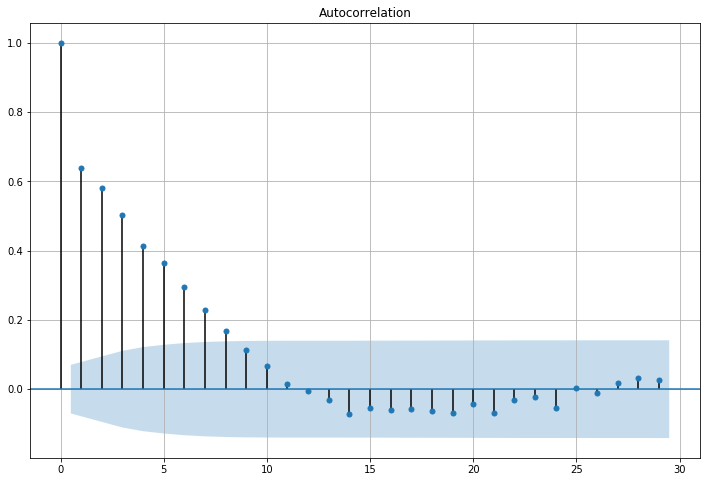

In [64]:
fig, ax = plt.subplots(figsize=(12, 8))
tsa.plot_acf(data_soi, ax=ax)
plt.grid()

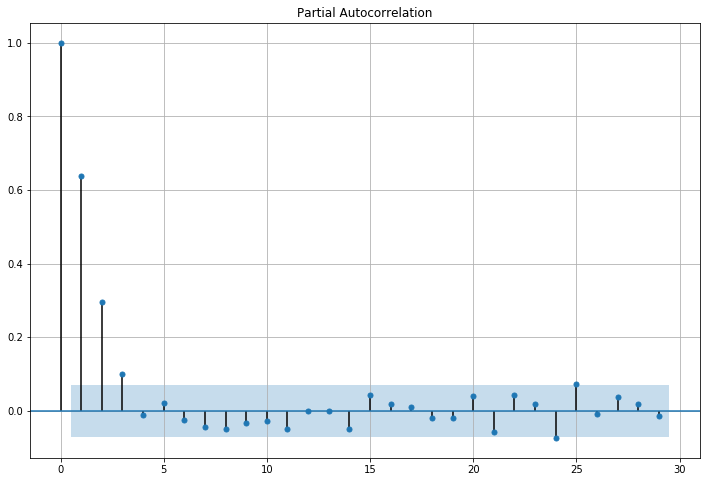

In [65]:
fig, ax = plt.subplots(figsize=(12, 8))
tsa.plot_pacf(data_soi, ax=ax)
plt.grid()

### Question 13

In [66]:
model_tsa = ARIMA(data_soi, order=(11,0,0))
model_fit_tsa = model_tsa.fit()

In [67]:
model_fit_tsa.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                              ARMA Model Results                              
==============================================================================
Dep. Variable:                      0   No. Observations:                  780
Model:                    ARMA(11, 0)   Log Likelihood                -817.296
Method:                       css-mle   S.D. of innovations              0.690
Date:                Sun, 26 Jan 2020   AIC                           1660.591
Time:                        03:05:58   BIC                           1721.162
Sample:                             0   HQIC                          1683.888
                                                                              
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.1324      0.086      1.539      0.124      -0.036       0.301
ar.L1.0        0.4156      0.036     11.615      0.000       0.345       0.486
ar.L2.0        0.2485      0.039      6.407      0.000       0.172       0.325
ar.L3.0        0.1009      0.040      2.534      0.011       0.023       0.179
ar.L4.0       -0.0079      0.040     -0.199      0.843      -0.086       0.070
ar.L5.0        0.0493      0.040      1.233      0.218      -0.029       0.128
ar.L6.0        0.0130      0.040      0.326      0.745      -0.065       0.091
ar.L7.0       -0.0127      0.040     -0.317      0.752      -0.091       0.066
ar.L8.0       -0.0221      0.040     -0.553      0.580      -0.101       0.056
ar.L9.0       -0.0128      0.040     -0.322      0.747      -0.091       0.065
ar.L10.0      -0.0084      0.039     -0.217      0.828      -0.085       0.068
ar.L11.0      -0.0498      0.036     -1.388      0.166      -0.120       0.021
                                    Roots                                     
==============================================================================
                   Real          Imaginary           Modulus         Frequency
------------------------------------------------------------------------------
AR.1             1.1173           -0.1936j            1.1340           -0.0273
AR.2             1.1173           +0.1936j            1.1340            0.0273
AR.3             0.9100           -0.9918j            1.3460           -0.1318
AR.4             0.9100           +0.9918j            1.3460            0.1318
AR.5            -1.3781           -0.0000j            1.3781           -0.5000
AR.6            -1.1143           -0.7357j            1.3353           -0.4071
AR.7            -1.1143           +0.7357j            1.3353            0.4071
AR.8             0.2646           -1.3594j            1.3849           -0.2194
AR.9             0.2646           +1.3594j            1.3849            0.2194
AR.10           -0.5732           -1.2245j            1.3520           -0.3197
AR.11           -0.5732           +1.2245j            1.3520            0.3197
------------------------------------------------------------------------------
"""

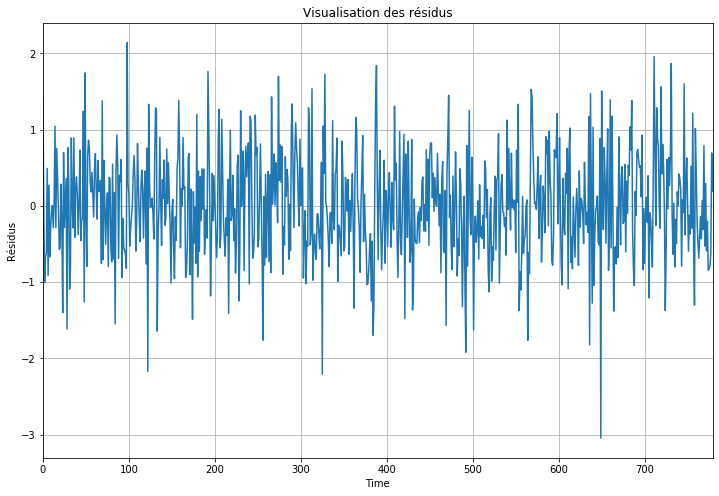

In [68]:
# plot residual errors
plt.figure(figsize = (12,8))
residuals_tsa = model_fit_tsa.resid
residuals_tsa.plot()
plt.grid()
plt.title('Visualisation des résidus')
plt.xlabel('Time')
plt.ylabel('Résidus')
plt.show()

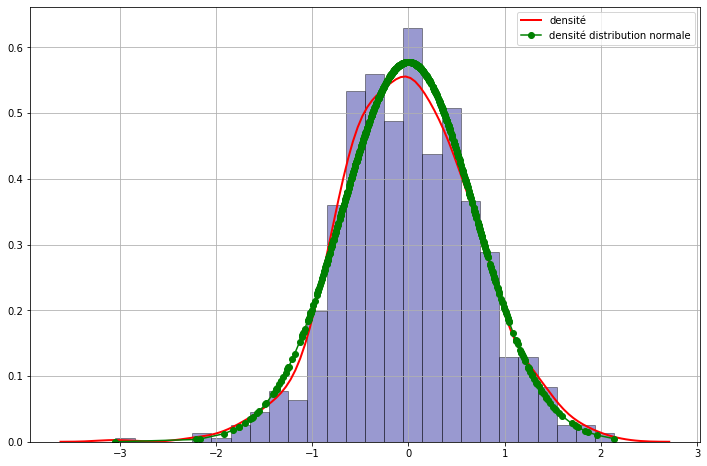

In [69]:
plt.figure(figsize = (12,8))
res_tsa = residuals_tsa.sort_values(0)
norm_tsa = stats.norm.pdf(res_tsa, np.mean(res_tsa), np.std(res_tsa))
sns.distplot(residuals_tsa, color = 'darkblue', hist = True, hist_kws={'edgecolor':'black'},
                 kde=True, kde_kws = {'color': 'red', 'lw': 2,  'label':'densité'})
plt.plot(res_tsa,norm_tsa,'-o', color='green', label='densité distribution normale')
plt.legend()
plt.grid()

On constate que les résidus suivent la même loi que la densité de distribution normale.

### Question 14

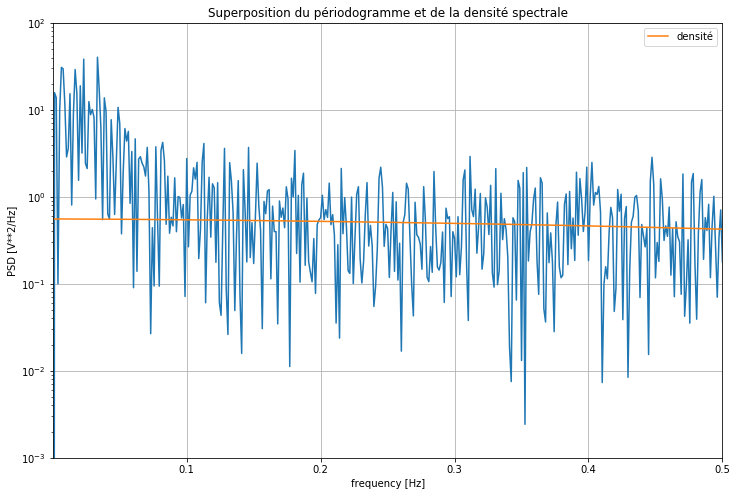

In [71]:
plt.figure(figsize = (12,8))
f, Pxx_den = signal.periodogram(data_soi[0])
plt.semilogy(f, Pxx_den)
residuals_tsa.plot(kind='kde', label='densité')
plt.title('Superposition du périodogramme et de la densité spectrale')
plt.xlabel('frequency [Hz]')
plt.ylabel('PSD [V**2/Hz]')
plt.xlim([1e-10, 0.5])
plt.ylim([1e-3, 1e+2])
plt.legend()
plt.grid()
plt.show()